# Making Business Decisions Based on Data - A/B Test Analysis

In this project, we will conduct an analysis for a big online store. There are several hypotheses that may help boost revenue, that need to be prioritized. Then, results of an A/B test should be analysed. The goal of this analysis is to determine whether the changes in group B should be implemented.

First, we will load all datasets, quickly go over them and prepare them for analysis. Then, hypotheses will be prioritized. In the final part, A/B tests results will be analyzed. 

## Data Preperation

In this section, all datasets will be loaded, examined and preprocessed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
## Load all 3 datasets

try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

try:
    orders = pd.read_csv('orders_us.csv',
                    parse_dates=['date'])
except:
    orders = pd.read_csv('/datasets/orders_us.csv',
                    parse_dates=['date'])

try:
    visits = pd.read_csv('visits_us.csv',
                        parse_dates=['date'])
except:
    visits = pd.read_csv('/datasets/visits_us.csv',
                    parse_dates=['date'])

### **`hypotheses`**

In [3]:
## Overview `hypotheses` dataset

hypotheses.info()
hypotheses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Effort        9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


**Conclusion**

No need to do any action in `hypotheses`.

### **`orders`**

In [4]:
## Overview `orders` dataset

orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


**Duplicates**

Let's see if there are any duplicates in `transactionId`.

In [5]:
if (orders['transactionId'].duplicated().sum()):
    print("There are duplicates in transactionId.")
else:
    print("No duplicates in transactionId.")

No duplicates in transactionId.


No duplicates. We can move on.

**Division to Groups**

Now, let's make sure that all users were assigned to the right group. We will check if any user has more than one unique group id.

In [6]:
## Find users with more than 1 group

orders.groupby('visitorId')['group'].nunique().sort_values(ascending=False).reset_index().head()

,visitorId,group
0,2579882178,2
1,2712142231,2
2,1668030113,2
3,1404934699,2
4,237748145,2


In [7]:
## Calculate counts to get better perspective

numBothGroups = orders.groupby('visitorId')['group'].nunique().sort_values(ascending=False).reset_index().query('group > 1').drop_duplicates()['visitorId'].count()
overallUsers = orders['visitorId'].nunique()

print('Number of users who were assigned to more than one group: {}.'
      .format(numBothGroups))
print('Overall number of unique users: {}.'
      .format(overallUsers))

Number of users who were assigned to more than one group: 58.
Overall number of unique users: 1031.


58 users were indeed recorded under both groups. This could mean that there's a problem with the test: it could be a problem with how we segment the users to the groups, and it better be checked. For now, we will remove them from the test by removing them from `orders` dataset.

In [8]:
## Prepare a list of visitorIds to be excluded

removeDoubleGroup = orders[orders['visitorId'].isin(
orders.groupby('visitorId')['group'].nunique().sort_values(ascending=False).reset_index().query('group > 1').drop_duplicates()['visitorId']
)]

## Exclude 58 users with double group value

orders = orders.drop(removeDoubleGroup.index)

## Calculate the number of users removed

print('Number of users removed: {}.'
      .format(overallUsers - orders['visitorId'].nunique()))

Number of users removed: 58.


Let's see now how users are divided between the groups.

In [9]:
orders.groupby(['group'])['visitorId'].nunique()

group
A    445
B    528
Name: visitorId, dtype: int64

There are more users in group B (54% to 46%). We need to keep that in mind in our analysis conclusions.

In [10]:
## General overview of `orders`

orders.describe()

,transactionId,visitorId,revenue
count,1.016000e+03,1.016000e+03,1016.000000
mean,2.155085e+09,2.128677e+09,130.770866
std,1.234372e+09,1.221578e+09,648.079810
min,1.062393e+06,5.114589e+06,5.000000
25%,1.143481e+09,1.043655e+09,20.775000
50%,2.144499e+09,2.150274e+09,50.100000
75%,3.256513e+09,3.146991e+09,126.950000
max,4.288552e+09,4.283872e+09,19920.400000


Looking at the maximum value for revenue, we see already a value that will probably have a great impact on the data.

In [11]:
## Checking the time period of the data

orders['date'].describe()

count                    1016
unique                     31
top       2019-08-05 00:00:00
freq                       43
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [12]:
## Checking if there are other group values than 'A' and 'B'

orders['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

**Conclusion**

Users that were assigned to both groups were removed and will not be part of the analysis. It should be noted that there are 9% more users in group B.
All seems fine now in `orders`.

### **`visits`**

In [13]:
## Print general overview of `visits`

visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [14]:
## Checking the time period of the data

visits['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [15]:
## Checking if there are other group values than 'A' and 'B'

visits['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [16]:
## General overview of `visits` column

visits['visits'].describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visits, dtype: float64

**Conclusion**

All seems fine in `visits`, no need for any preprocessing measure.

### Missing values
We will check whether there are missing values in any of the datasets.

In [17]:
## Check for missing values

if (hypotheses.isnull().sum().sum() == 0):
    print('No missing values in `hypotheses`.')
else:
    print('There are missing values in `hypotheses`.')

if (orders.isnull().sum().sum() == 0):
    print('No missing values in `orders`.')
else:
    print('There are missing values in `orders`.')

if (visits.isnull().sum().sum() == 0):
    print('No missing values in `visits`.')
else:
    print('There are missing values in `visits`.')
    

No missing values in `hypotheses`.
No missing values in `orders`.
No missing values in `visits`.


There are no missing values in both datasets.

### Conclusions

In `orders` dataset, some user Ids were assigned to both groups, A and B. This should not happen: there might have been a problem in the way the groups were assigned, and it better be checked. For the purposes of this analysis, these users' data will be excluded from the analysis and removed from the dataset. 

Duplicated values and missing values were checked - none of them exist in any of the datasets.

It should also be noted that there are 9% more users in group B.

No action was required in `visits` and `hypotheses` sets.

The data are now ready for analysis.

## Prioritizing Hypotheses

In this section, the hypotheses in `hypotheses` dataset will be prioritized. This part will follow this structure:
- Prioritizing by 'ICE' framework.
- Prioritizing by 'RICE' framework.
- Examination of the differences in the two frameworks.

In [18]:
## Overview of the hypotheses

hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


### 'ICE'
'ICE' framework is calculated as: Impact * Confidence / Effort.

In [19]:
## Calculate 'ICE' to a new column

hypotheses['ICE'] = hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']

## Print hypotheses by 'ICE'

hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Hypothesis 8, 0 and 7 got the highest 'ICE' rate.

### 'RICE'
'RICE' framework is calculated as: Reach* Impact * Confidence / Effort.

In [20]:
## Calculate 'RICE' to a new column

hypotheses['RICE'] = hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']

## Print hypotheses by 'RICE'

hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Hypothesis 7, 2 and 0 are the highest according to RICE framework (with 7 far from the rest).

### Conclusions

Hypotheses 7 and 0 were among the top 3 in both frameworks. However, two major changes occured. First, while the two hypotheses were close in 'ICE', hypothesis 7 got a much higher rate in 'RICE'.

Also, hypothesis 8 was among the top 3 in 'ICE', but dropped in 'RICE'. Similar but opposite trend happened to hypothesis 2, which climbed to second place in 'RICE'.

The reason must be differences in the 'Reach' attribute that was introduced in 'RICE'.

Hypothesis 7 has a reach score of 10, while hypothesis 0 has only 3. This explains the large gap between them in 'RICE'. In a similar manner, hypothesis 8 has a reach score of 1, while hypothesis 2 has a reach of 8.

If hypotheses need to be chosen, then hypotheses 7 and 0 would definitely be first, as they were among the top 3 in both frameworks. Hypotheses 2, 8 will be next, as they achieved high scores in at least one of the frameworks.

## A/B Test Analysis

In this section, results of an A/B test will be analyzed using the data in `visits` and `orders`. The analysis will include the following steps:
1. Setting up cumulative data.
2. Revenue by group - Cumulative revenue by group.
3. Average order size - Cumulative average order size by group and relative difference of the groups.
4. Conversion rates by group.
5. Anomalies examination - scatter plots and 95th+ percentiles calculations.
6. Conclusions - mid-way conclusions.
7. Statistical differences - Raw data.
8. Statistical differences - Filtered data.
9. Test conclusions - Can conclusions of the test be derived?

### Setting up Cumulative Data

In order to get the cumulative data, we need to make some calculations and create a new table that will store the cumulative values. We will use this table for all cumulative data. This table will include besides revenues, also the number of orders, visitors and visits. We will use it later. To do so, we need to follow these steps:
1. Create an array with unique paired date-group values.
2. Add the required cumulative data for each row using .apply method.

First, we'll start by creating date-group array.

In [21]:
## create a paired date-group array

datesGroups = orders[['date', 'group']].drop_duplicates()

Now, for each row we will add the number that was accumulated to the respective date from `orders` table.
- `transactionId` will give us the number of unique orders.
- `visitorId` will give us the number of unique buyers.
- `revenue` will give us the sum of revenues.

In [22]:
## Using apply to get cumulative data up to each row in `datesGroups`

ordersAggregated  = (
    datesGroups
    .apply(lambda x:
          orders[np.logical_and(
          orders['date'] <= x['date'], orders['group'] == x['group'])]
          .agg({'date': 'max', 'group': 'max',
               'transactionId': pd.Series.nunique,
               'visitorId': pd.Series.nunique,
               'revenue': 'sum'}), axis=1
          ).sort_values(by=['date', 'group'])
)

We will do the same thing for `visits`.
- `visits` will give us the sum of visits.

In [23]:
## Doing the same as previous step, this time to `visits`

visitsAggregated  = (
    datesGroups
    .apply(lambda x:
          visits[np.logical_and(
          visits['date'] <= x['date'], visits['group'] == x['group'])]
          .agg({'date': 'max', 'group': 'max',
               'visits': 'sum'}), axis=1
          ).sort_values(by=['date', 'group'])
)

Now we will simply merge our two new tables, `ordersAggregated` and `visitsAggregated`.

In [24]:
## Merging the tow tables to one

cumulativeData = ordersAggregated.merge(visitsAggregated, 
                                       on=['date', 'group'])

## Rename columns

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']


 Cumulative data is now stored in the table `cumulativeData`, and we can continue to the analysis.
 
 ### Revenue by Group
 
Cumulative revenues will be drawn from `cumulativeData` column for each group, and plotted in a graph.

In [25]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

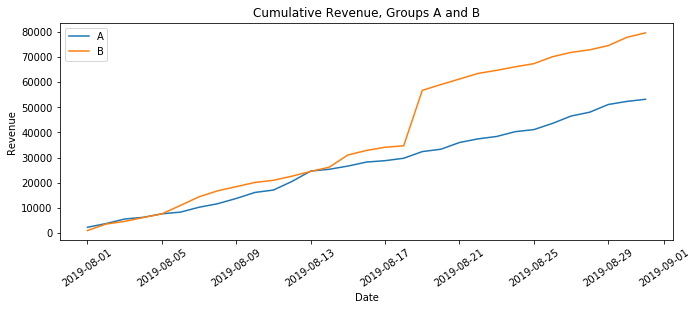

In [26]:
## Draw revenue data per date for each group

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue']]

## Plot revenue by group

plt.figure(figsize=(11,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=35)

plt.title('Cumulative Revenue, Groups A and B');
plt.xlabel('Date');
plt.ylabel('Revenue');

plt.legend();

The graph shows that revenues are constantly rising, with revenues for group B higher than in A. We also see a spike in group B around the 17th, which could mean a surge in the number of orders or a very high order was places. This is possibly an outlier -we will check that later. 

We should also remember that group B has more visitors, and it probably contributed to the differences.

### Average Order Size

Average order size will also use the cumulative data. We will use revenue over orders data to calculate the average.

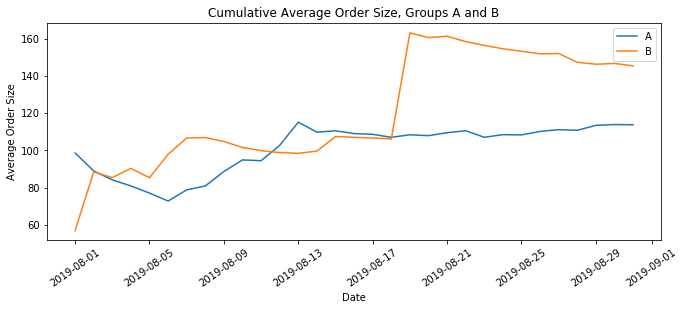

In [27]:
## Draw revenue and orders data per date for each group

cumulativeAvgOrderA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeAvgOrderB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

## Plot average order size by group

plt.figure(figsize=(11,4))
plt.plot(cumulativeAvgOrderA['date'], cumulativeAvgOrderA['revenue']/cumulativeAvgOrderA['orders'], label='A')
plt.plot(cumulativeAvgOrderB['date'], cumulativeAvgOrderB['revenue']/cumulativeAvgOrderB['orders'], label='B')

plt.xticks(rotation=35)

plt.title('Cumulative Average Order Size, Groups A and B');
plt.xlabel('Date');
plt.ylabel('Average Order Size');

plt.legend();

Avergae order size for group A stabilizes around 120. We can see the surge in group B's average order size that suggest a large order taken place there. We can also see that the average revenue for group B was dropping towards the end, possibly starting to stabilize.

We will now plot the relative difference in average order size between the two groups. We will first merge average order size data of both groups, then plot the graph.

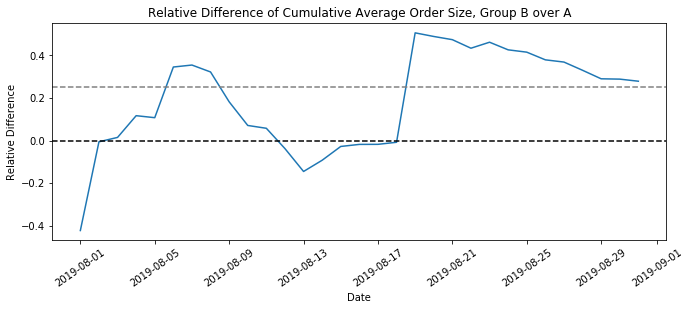

In [28]:
cumulativeAvgOrder = cumulativeAvgOrderA.merge(cumulativeAvgOrderB, on='date', suffixes=['A', 'B'])

plt.figure(figsize=(11,4))
plt.plot(cumulativeAvgOrder['date'], (cumulativeAvgOrder['revenueB']/cumulativeAvgOrder['ordersB'])/(cumulativeAvgOrder['revenueA']/cumulativeAvgOrder['ordersA'])-1)

plt.xticks(rotation=35);

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.25, color='grey', linestyle='--');

plt.title('Relative Difference of Cumulative Average Order Size, Group B over A');
plt.xlabel('Date');
plt.ylabel('Relative Difference');

Spikes are visible here as well. Towards the end of the graph, the difference starts to stabilize with a minor decrease at 0.25. This means that the average order size of group B is 25% higher.

### Conversion Rate

In this section, conversion rate will be calculated for each group and will be plotted in one graph. We will use the cumulative data of orders and visits to calculate it.

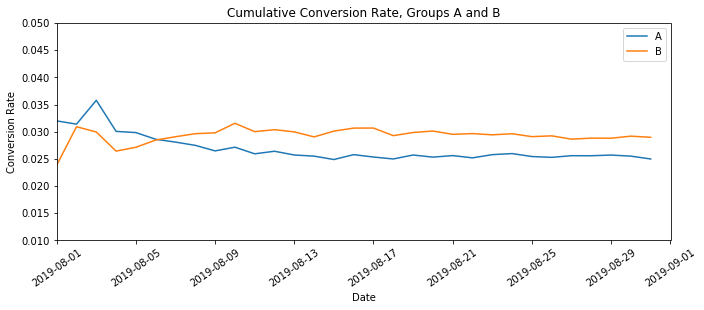

In [29]:
## Create a new column, `conversion`

cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visits']

## Get conversion rates of each group

cumulativeConversionA = cumulativeData[cumulativeData['group']=='A'][['date', 'conversion']]
cumulativeConversionB = cumulativeData[cumulativeData['group']=='B'][['date', 'conversion']]

## Plot conversion data

plt.figure(figsize=(11,4))
plt.plot(cumulativeConversionA['date'], cumulativeConversionA['conversion'], label='A')
plt.plot(cumulativeConversionB['date'], cumulativeConversionB['conversion'], label='B')

plt.xticks(rotation=35)

plt.title('Cumulative Conversion Rate, Groups A and B');
plt.xlabel('Date');
plt.ylabel('Conversion Rate');

plt.legend();

plt.axis(['2019-08-01', '2019-09-01', 0.01, 0.05]);

Conversion rates seem to have been stablized with a 0.5% higher rate for group B.

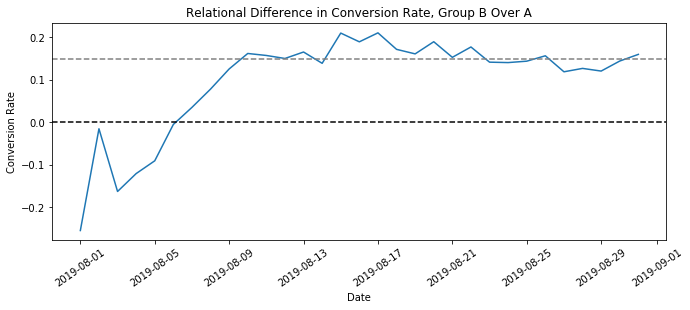

In [30]:
## Merge cumulative conversion rates

cumulConversion = pd.merge(cumulativeConversionA, cumulativeConversionB, on='date', suffixes=['A', 'B'])

## Plot relational difference for conversion rates

plt.figure(figsize=(11,4))
plt.plot(cumulConversion['date'], cumulConversion['conversionB']/cumulConversion['conversionA']-1)

plt.xticks(rotation=35)

plt.title('Relational Difference in Conversion Rate, Group B Over A');
plt.xlabel('Date');
plt.ylabel('Conversion Rate');

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.15, color='grey', linestyle='--');

Relational difference in conversion rate is currently almost 15% higher in group B and rising.

### Anomalies Examination

In this section, we will start exploring anomalies in the data. We will explore two parameters: number of orders per user and order prices. This will be done by creating scatter plot and calculating the 95th and 99th percentiles.

**Number of Orders per User**

We will start with number of orders per user:
- Scatter plot of orders per user.
- 95th and 99th percentiles.

First, we will need to calculate the number of orders for each user.

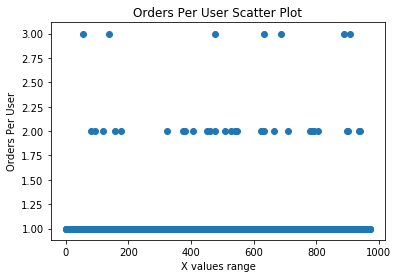

In [31]:
## Get number of orders for each user

orders_per_user = orders.groupby('visitorId').agg({'transactionId': 'count'}).reset_index()
orders_per_user.columns = ['visitorId', 'orders']
## Get a range for the x axis

n_orders_x_values = pd.Series(range(0, len(orders_per_user)))

## Plot a scatter plot for orders per user

plt.scatter(n_orders_x_values, orders_per_user['orders']);
plt.title('Orders Per User Scatter Plot')
plt.xlabel('X values range')
plt.ylabel('Orders Per User');

Most frequently, each user has only 1-2 orders. Significantly smaller portion has 3 to 5 orders. There are also some users with more than 8 orders. 

Let's now calculate the 95th and 99th percentiles of the number of orders per user.

In [32]:
## Calculate and print percentiles

order_per_user_centiles = np.percentile(orders_per_user['orders'], [95, 99])

print('95th Percentile for orders per user: {}'
     .format(order_per_user_centiles[0]))
print('99th Percentile for orders per user: {}'
     .format(order_per_user_centiles[1]))

95th Percentile for orders per user: 1.0
99th Percentile for orders per user: 2.0


95% of the users have a maximum of 2 orders, and 99% of the users has up to 4 orders. We can say that more than 2 orders per user becomes an anomaly.

**Order Prices**

We will go through the same process for order prices. 

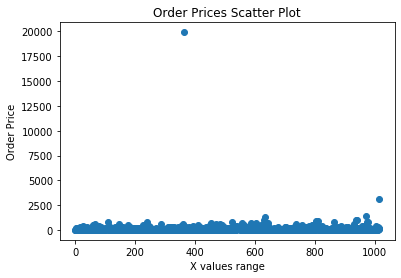

In [33]:
## Get order prices

order_prices = orders['revenue']

## Get a range for the x axis

order_prices_x_values = pd.Series(range(0, len(order_prices)))

## Plot a scatter plot for order prices

plt.scatter(order_prices_x_values, order_prices);
plt.title('Order Prices Scatter Plot')
plt.xlabel('X values range')
plt.ylabel('Order Price');

Seems like most orders had a price of not more than 1,500. However, there's one order with a price of 2,500 and another one at 20,000, much higher than the rest of the orders.

Let's calculate the percentiles.

In [34]:
## Calculate and print percentiles

orders_price_centiles = np.percentile(order_prices, [95, 99])

print('95th Percentile for order price: {}'
     .format(orders_price_centiles[0]))
print('99th Percentile for order price: {}'
     .format(orders_price_centiles[1]))

95th Percentile for order price: 414.275
99th Percentile for order price: 830.3


95% of the orders are less than 435. 99% of it is less than 900. It's seem safe to use here as well the 95% percentile as our border for anomalies. Not many orders seem to be higher than 500. 

### Conclusions

The A/B tests results so far shows that the revenue of both groups growing constantly. Revenue in group B was higher, possibly as a result of outliers. 

Average order size had a lot of flunctuations and stabilized with an advantage for group B that was higher by 25%. Here as well, data is probably affected by outliers. 

Conversion rate for group B stabilized at 3.5%, higher by 0.5% than conversion rate in group A.

Anomaly data limits were also set. 95% of the users had no more than 2 orders, while 95% of the orders were 435 and below. Data higher than that will be considered an anomaly.

### Statistical Differences - Raw Data

Now, let's calculate the statistical significace of the difference between the groups. We will do that for conversion and average order size. In this section, **raw data** will be used.

#### Conversion Rate

Let's calculate the statistical significance of conversion rate using the raw data.

First, we need to prepare the data for the statistical test. We will create a dataset with user Ids and their number of orders. The mean of this group is also the conversion rate (sum of orders / number of users).

In [35]:
## Create datasets with users and their number of orders

ordersByUsersA = (
    orders[orders['group']=='A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group']=='B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

The tables we just created will only show users who placed an order. However, to calculate the conversion, we also need to count users who placed 0 orders. We will create a series with zero values for the users who didn't place an order.

In [36]:
## Create a series for users who didn't place an order. Set value 0

zeroOrdersA = pd.Series(0,
                        index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA)),
                        name='orders')
zeroOrdersB = pd.Series(0,
                        index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB)),
                        name='orders')

Now we just need to concat the 4 serieses to 2, one for each group.

In [37]:
## Concat the serieses

sampleA = pd.concat([ordersByUsersA['orders'], zeroOrdersA], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], zeroOrdersB], axis=0)

We're ready to calculate the statistical significance.

Our null hypothesis is that conversion rate in group A and group B are equal. The alternative hypothesis is that conversion rate for the two groups is different. 

In [38]:
## Calculate statistical significance of conversion rate

print('P-value: {0:.3f}.'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Conversion rate Difference: {0:.3f}.'.format(sampleB.mean()/sampleA.mean()-1))

P-value: 0.006.
Conversion rate Difference: 0.160.


P-value is smaller than 0.05 - we can reject the null hypothesis. This means that the difference of conversion rate between the two groups is statistically significant. 

Conversion rate for group B is higher by 13.8%. 

#### Average Order Size

Let's do the same process now for average order size.

Our null hypothesis is that the average order size is the same in group A and group B. 
The alternative hypothesis is that the groups' average order size is different.

In [39]:
## Calculate statistical significance of average order size

print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('Average Order Size Difference: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.431
Average Order Size Difference: 0.278


P-value is higher than 0.05 - so there is no reason to conclude that there's a difference in average order size between the groups. Still, average order size is higher in group B by 25%. 

#### Conclusions

Raw data shows that there is a difference in conversion rates of the two groups, with conversion rate **higher by 13.8% in group B**.

In average order size, however, there's no statistical significance of a difference between the groups. Even so, relational difference was 25% in favor of group B.

### Statistical Differences - Filtered Data

In this section, we will calculate the statistical significance of the difference between group A and B using the filtered data, after removing anomalies. Here as well, conversion rate and average order size will be calculated.

#### Anomalies Removal

First, we'll gather all anomalies together, so they could be easily excluded. In a previous sections we set the border over which data can be defined as anomaly:
- Users with more than 2 orders.
- Orders of more than 435.

We will gather the visitorId of users who answer these conditios.

In [40]:
## Get visitorId of anomalies (users with more than 2 orders, orders higher than 435)

manyOrders = pd.concat([
    ordersByUsersA[ordersByUsersA['orders']>2]['visitorId'],
    ordersByUsersB[ordersByUsersB['orders']>2]['visitorId']
    ], axis=0)

expensiveOrders = orders[orders['revenue']>435]['visitorId']

## Group all abnormal users into one series

abnormalUsers = pd.concat([manyOrders, expensiveOrders],
                         axis=0).drop_duplicates().sort_values()

## Print overall count of abnormal users

print('Number of abnormal Users to be excluded: {}.'.format(abnormalUsers.shape[0]))

Number of abnormal Users to be excluded: 56.


75 users are abnormal by our definitions and will be filtered out in this section. We'll now create two filtered samples.

In [41]:
## Create filtered samples

sampleAFiltered = (
    pd.concat(
    [
        ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                      .isin(abnormalUsers))]['orders'],
        pd.Series(0,
                  index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),
                  name='orders')], axis=0)
)

sampleBFiltered = (
    pd.concat(
    [
        ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                      .isin(abnormalUsers))]['orders'],
        pd.Series(0,
                  index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),
                  name='orders')], axis=0)
)

#### Conversion Rate

We will now use the filtered samples to calculate the statistical significance of the difference in conversion rates between the groups.

Our null hypothesis says that conversion rate is equal in group A and group B.
Alternative hypothesis is that the conversion rate is different in the two groups.

In [42]:
## Calculate statistical significance and relational difference

print('P-Value: {0:.3f}.'.format(stats.mannwhitneyu(sampleAFiltered, 
                                        sampleBFiltered)[1]))
print('Difference in conversion rate: {0:.3f}.'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-Value: 0.005.
Difference in conversion rate: 0.186.


P-value is lower than 0.05, which means that the two groups' conversion rates are different. Group B has a conversion rate higher by 17%.

P-value almost did not change after removing the abnormal users, and still shows a difference between the groups. However, the difference between the groups is now 4% larger, with 17% now compared to 13% before.

#### Average Order Size

Let's now check the statistical significance of the difference in average orders size for the filtered data.

The null hypothesis is that average order size is equal in both groups. The alternative hypothesis says that the average order size is different in group A and group B.

In [43]:
## Get revenue of the filtered data

revenueAFiltered = (
    orders[np.logical_and(
            orders['group']=='A',
            np.logical_not(orders['visitorId']
                           .isin(abnormalUsers)))]['revenue']
)

revenueBFiltered = (
    orders[np.logical_and(
            orders['group']=='B',
            np.logical_not(orders['visitorId']
                           .isin(abnormalUsers)))]['revenue']
)

## Calculate statistical significance and relational difference

print('P-Value: {0:.3f}'.format(stats.mannwhitneyu(revenueAFiltered, revenueBFiltered)[1]))
print('Difference in average order size: {0:.3f}'.format(revenueBFiltered.mean()/revenueAFiltered.mean()-1))

P-Value: 0.379
Difference in average order size: -0.031


P-value is higher than 0.05. We cannot rule out the possibility that the average order size is the same. The average order size was higher by 2.7% in group A.

P-value didn't change much after removing abnormal users, but the difference between the groups now changed: Group A has a slightly higher average.

#### Conclusions

75 users were classified as anomalies and exlucded from the filtered data. 

Statistical significance test showed once again that conversion rate is different between the group. In the filtered data, conversion rate in group B was higher by 17%, an even bigger gap than in the raw data.

Average order size again showed no difference between the groups in the statistical test. However, In the filtered data the average order size was actually higher in group A by 2.7%.

### Test Conclusions

In this section, A/B tests results will be concluded. We will also take a decision based on the result to see if the test needs to continue or concluded.

**Revenue** - Revenue in both groups rose constantly, with group B having higher revenues.

**Average order size** - Raw data shows a higher average order size in group B by 25%. However, statistical significance test showed that there was no difference between the groups in terms of average order size.

Testing statistical significance using the filtered data showed once again no difference between the groups. However, average order size in the filtered data was higher this time in **group A** by 2.7%. 

**Conversion rate** - In raw data, conversion rate stablized at 3.5% in group B compared to only 3% in group A. Statistical significance test also showed a difference between the groups and a relational difference of 13.8%.

Filtered data had no change in the statistical test results, but a higher difference of 17% between the groups.

**Summary**

1. There's no statistically significant difference between the groups in terms of average order size, and it seems to have stabilized.
2. There's a statistically significant difference between the groups in terms of conversion rates. Conversion rate is higher by 13-17% in **group B**, and the gap seems to get larger.

**Decision:** Since there's no difference in average order size, and conversion rate is much higher in group B, **we can stop the test and consider group B as the leader**. 